In [88]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
ds.update_views(materialize=True)

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']
[dp] execute c:\wenyan\dse_capstone\database\preprocess.sql
[dp] execute c:\wenyan\dse_capstone\database\materialize.sql


In [5]:
df_transaction = ds.get_view_df('property_transaction_valid')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1369868, 23)
(709325, 20)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
# records of all years
df_all_valid = pp.dataset(feature='all', valid=True)
df_all_valid.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(1369868, 24)

In [8]:
# records of last year
df_last_year_valid = pp.dataset(feature='all', valid=True, date=('2016-10-01', '2017-10-01'))
df_last_year_valid.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(34192, 24)

In [9]:
df_last_year_valid.head()

,impr_over_land,sqft_price,year_built,sold_age,street,view,sold_price,eval_land,num_bath,usable_sqft,...,sale_count_zip,date,sold_price_zip_avg,num_bed,prop_count_zip,sqft_zip_avg,sqft,zip,sold_year,eval_imps
0,1.902470,277,1975.0,42.0,LAKE MURRAY,0,270000,45258,2,NaN,...,481,2017-09-27,497397.089397,2,8521,1488.16632,973,92119,2017,86102
1,0.923082,297,1973.0,44.0,TOMMY,0,315000,97077,1,NaN,...,481,2017-09-27,497397.089397,2,8521,1488.16632,1060,92119,2017,89610
2,0.456311,382,1974.0,43.0,STONEVIEW,1,675000,412000,2,5700.0,...,481,2017-09-25,497397.089397,3,8521,1488.16632,1766,92119,2017,188000
3,2.272765,445,1964.0,53.0,GAIN,0,668000,152776,3,7100.0,...,481,2017-09-22,497397.089397,4,8521,1488.16632,1500,92119,2017,347224
4,0.450194,480,1961.0,56.0,TOMMY,1,529000,274919,2,5700.0,...,481,2017-09-22,497397.089397,3,8521,1488.16632,1100,92119,2017,123767


In [12]:
use_features = pp.get_feature_list()
use_features.remove('date')
print(use_features)
X = df_last_year_valid[use_features]
y = np.ravel(df_last_year_valid['sold_price'])
print(X.shape)
X[:3]

['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land', 'lon', 'lat']
(34192, 11)


,sqft,num_bed,num_bath,view,pool,sqft_zip_avg,sqft_price_zip_avg,sold_price_zip_avg,impr_over_land,lon,lat
0,973,2,2,0,0,1488.16632,338.174636,497397.089397,1.902470,-117.01258,32.80013
1,1060,2,1,0,0,1488.16632,338.174636,497397.089397,0.923082,-117.02621,32.80389
2,1766,3,2,1,0,1488.16632,338.174636,497397.089397,0.456311,-117.04077,32.81066


### LinearRegression

In [91]:
rr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ElasticNet(random_state=42))
     ])

parameters = {'clf__l1_ratio': np.arange(0.05,0.2,0.02),
              'clf__alpha': np.arange(0.01,0.07,0.02)}
model = GridSearchCV(rr, parameters, cv=3, verbose=True, n_jobs=-1)

mm = ModelManager(df_last_year_valid, use_features, 'sold_price', model)
mm.run()
mm.summary()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   11.2s finished
[dp] best params: {'clf__l1_ratio': 0.19, 'clf__alpha': 0.01}
[dp] best score: 0.7738151624147541
[dp] cv results:
{'mean_fit_time': array([ 0.16295028,  0.399242  ,  0.44518518,  0.38218387,  0.42630037,
        0.4039073 ,  0.39889407,  0.4176085 ,  0.22526574,  0.22409685,
        0.26888116,  0.27590124,  0.2489961 ,  0.24364694,  0.26721104,
        0.25785263,  0.17730554,  0.18966826,  0.185661  ,  0.18348853,
        0.19117538,  0.18582741,  0.17763901,  0.12600088]),
 'mean_score_time': array([ 0.00233714,  0.00350857,  0.00317574,  0.00367649,  0.00334223,
        0.00350968,  0.00317613,  0.00284036,  0.00334581,  0.00334342,
        0.00334255,  0.00367681,  0.00350944,  0.00384577,  0.0038445 ,
        0.00434526,  0.00367665,  0.00317558,  0.00350889,  0.0035104 ,
        0.00350928,  0.00351508,  0.00350992,  0.00300821]),
 'mean_test_scor

[dp] training error: 167744.9570565966
[dp] testing error: 177165.71244670183


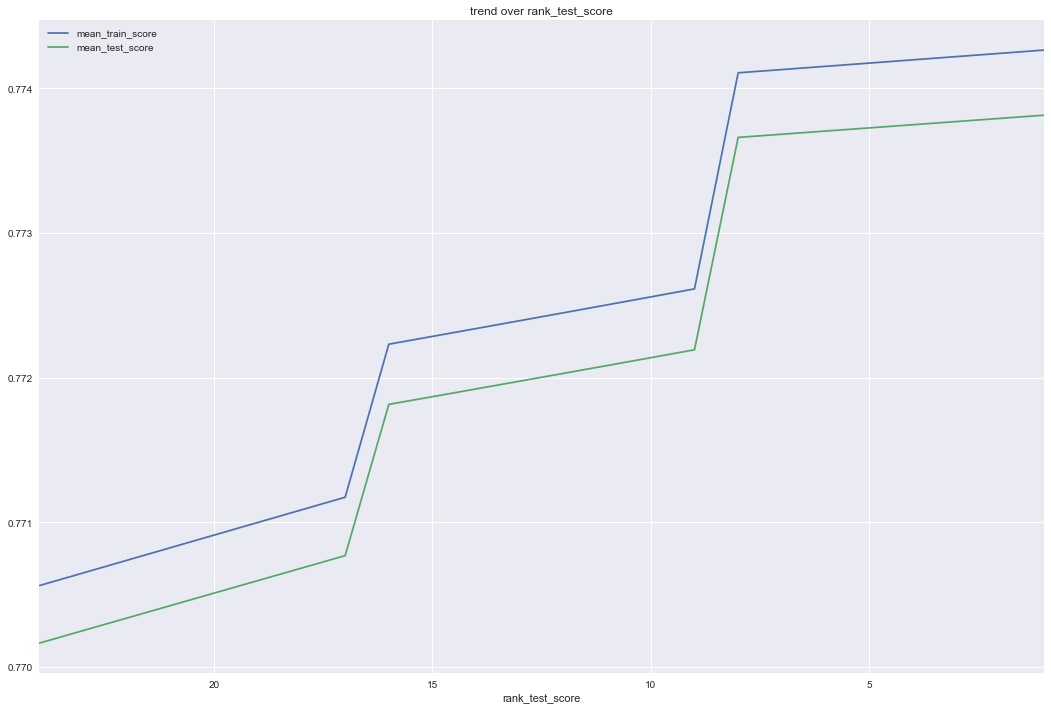

[{'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.050000000000000003},
 {'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.070000000000000007},
 {'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.090000000000000011},
 {'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.11000000000000001},
 {'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.13},
 {'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.15000000000000002},
 {'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.17000000000000004},
 {'clf__alpha': 0.049999999999999996, 'clf__l1_ratio': 0.19},
 {'clf__alpha': 0.029999999999999999, 'clf__l1_ratio': 0.050000000000000003},
 {'clf__alpha': 0.029999999999999999, 'clf__l1_ratio': 0.070000000000000007},
 {'clf__alpha': 0.029999999999999999, 'clf__l1_ratio': 0.090000000000000011},
 {'clf__alpha': 0.029999999999999999, 'clf__l1_ratio': 0.11000000000000001},
 {'clf__alpha': 0.029999999999999999, 'clf__l1_ratio': 0.13},
 {'clf__alpha': 0.029999999999999999, 

In [92]:
mm.plot_learning_curve()

## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [93]:
ntrees = np.arange(40,200,40)
depths = np.arange(5,20)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}
rf = RandomForestRegressor(n_jobs=-1, random_state=17)
model = GridSearchCV(rf, parameters, cv=3, verbose=True, n_jobs=-1)
mm = ModelManager(df_last_year_valid, use_features, 'sold_price', model)
mm.run()

mm.summary()

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 10.7min finished
[dp] best params: {'max_depth': 18, 'n_estimators': 180}
[dp] best score: 0.8738131457165803
[dp] cv results:
{'mean_fit_time': array([  0.39690661,   2.88282744,   3.86812178,   5.55477317,
         6.56529323,   1.32351987,   2.31164797,   4.35274267,
         7.20533029,   7.86241102,   1.77288198,   2.77421172,
         5.21954878,   7.80525899,   8.98757044,   1.91041446,
         3.56381138,   6.60941235,   9.17891177,  10.40634322,
         1.90924454,   4.17476924,   7.26582511,  10.34818896,
        11.78099728,   2.29811255,   5.12780484,   8.83616765,
        11.33982563,  13.27413662,   2.22625383,   5.69564756,
         8.95247666,  13.00191275,  14.70193394,   2.63066284,
         5.95316537,   9.34084217,  13.51109982,  16.51826469,
         3.26819181,   7.2756865 ,  12.09032146

[dp] training error: 51308.84655736554
[dp] testing error: 121790.11470871451


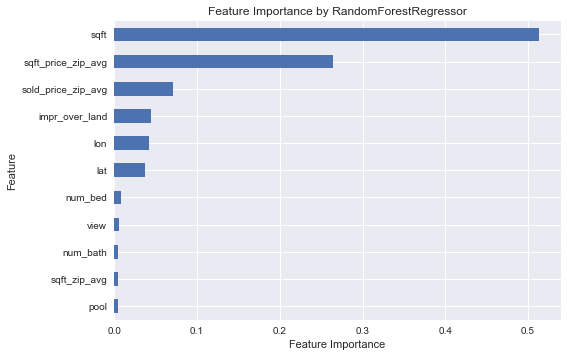

In [94]:
mm.plot_feature_importance()

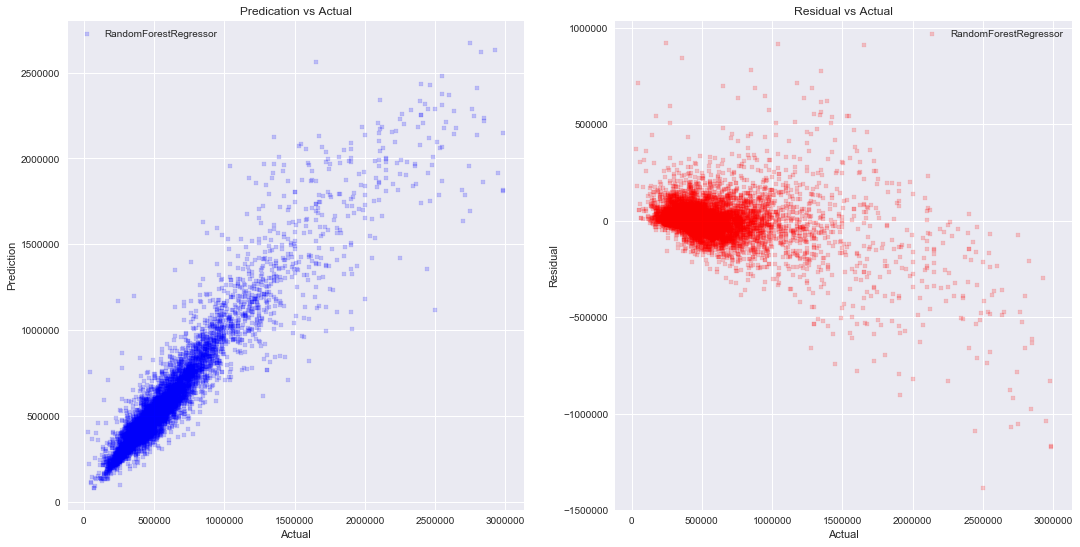

In [95]:
mm.plot_residual()

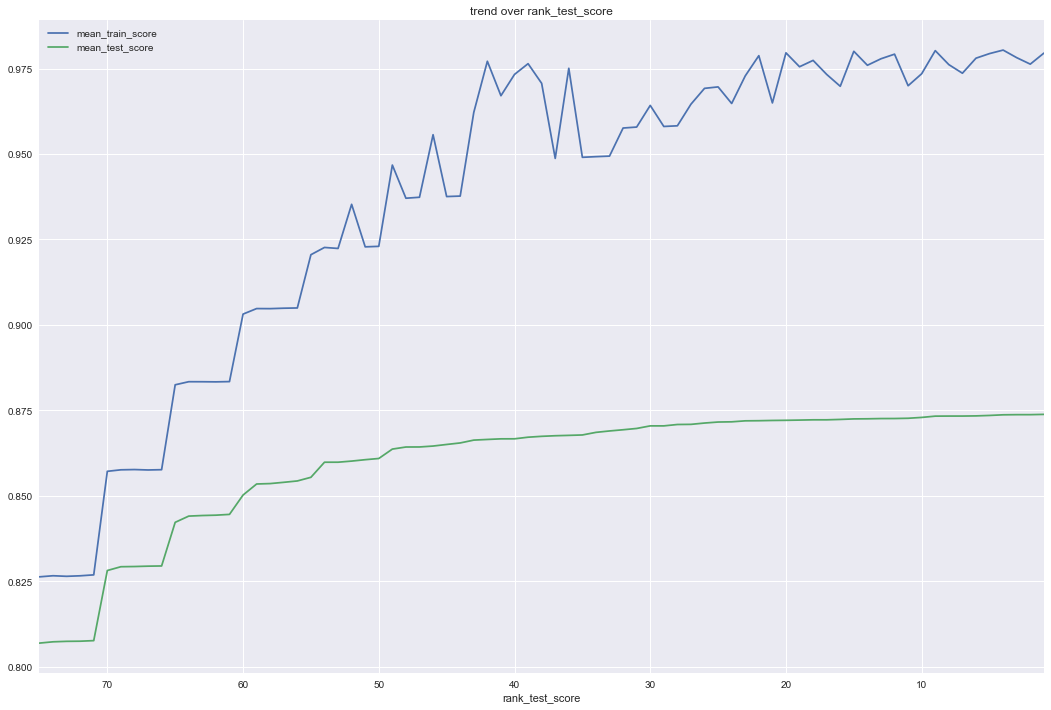

In [97]:
ranked_params = mm.plot_learning_curve()